In [1]:
import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
from sklearn.linear_model import LogisticRegressionCV

In [2]:
input_data = pk.load(open('input_data.pkl', 'rb'))
target_data = pk.load(open('target_data.pkl', 'rb'))

pooling = []
dimention = []
score = []

for pooling_name, pooling_function in zip(['Max Pooling', 'Mean Pooling'], [np.max, np.mean]):
    for dim in np.power(2, np.arange(12)):
        scores = []
        for i in range(5):
            log_input = []
            random_embedding = (np.random.rand(input_data[0].shape[1], dim) * 2 - 1) * np.sqrt(input_data[0].shape[1])
            for input_batch in input_data:
                embedded_input = np.dot(input_batch, random_embedding)
                embedded_input = pooling_function(embedded_input, axis=0)
                log_input.append(embedded_input)
            log_input = np.stack(log_input)
            cvlr = LogisticRegressionCV(Cs=1, cv=10, scoring='roc_auc', max_iter=10000)
            each_score = []
            for t in np.array(target_data).T:
                t = t.astype('int')
                cvlr.fit(log_input, t)
                each_score.append(np.mean(cvlr.scores_[1]))
            scores.append(np.mean(each_score))
        pooling.append(pooling_name)
        dimention.append(dim)
        score.append(np.mean(scores))

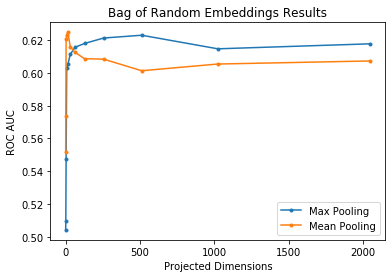

In [3]:
plt.figure()
plt.plot(dimention[:12], score[:12], marker='.', label='Max Pooling')
plt.plot(dimention[12:], score[12:], marker='.', label='Mean Pooling')
plt.xlabel('Projected Dimensions')
plt.ylabel('ROC AUC')
plt.title('Bag of Random Embeddings Results')
plt.legend()
plt.show()